# Notes on the guess-and-iterate method

# Example of things gone wrong

Sometimes, the way you setup the two equations to iterate makes the difference between finding a solution or getting incoherent results in a few steps.

As an example of this phenomenon, consider question 2 from hw08.  This is a topologically similar circuit to the one of this assignment but with different numbers and equations for the diode.  The concepts shown and discussed below are the same, however.

First step is to construct the two mutually-coupled equations with which to iterate.  How about the given equation for the diode current as a function of diode voltage:

\begin{equation}
i_x = 10^{-12} \bigl[\exp(v_D/V_T) -1 \bigr]
\end{equation}

Then $v_D$ as a function of $i_x$ using Ohm's law and KVL with the resistor:

\begin{equation}
v_D = 3.3 - 500 \cdot i_x
\end{equation}

Set these up as functions:

In [1]:
from numpy import exp

# id equation from the diode
def ix_d(vd):
    return 1e-12 * (exp(vd/26e-3) - 1)

# vd equation from the resistor
def vd_r(ix):
    return 3.3 - 500*ix

# Compute and show the individual steps

The below function accepts two functions and an initial guess.  It is the python code version of our guess-and-iterate procedure.

In [2]:
def iterate(func1, func2, guess,
            tol=1e-5,
            verbose=True,
            maxiter=100):
    """Iterates two mutually-coupled equations starting from a first
    guess of y=func1(guess), then x=func2(y), then y=func1(x),
    and so on until:
        a) the relative change in is less than tol
        b) the maximum number of iterations is reached
    """

    i = 0

    #function evaluation wrapper to print its results at each step
    def doit(f, x):
        #print the failing step before raising the original exception
        try:
            y = f(x)
        except:
            if verbose:
                print('%i: %s( %9.2e ) = *FAIL*' % (i, f.__name__, x))
            raise
            
        if verbose: print('%i: %s( %+9.2e ) => %9.2e' % (i, f.__name__, x, y))
        return y
    
    #manually do the first step so we have two values of each variable
    x_last = guess
    y_last = doit(func1, guess)
    i += 1
    
    x = doit(func2, y_last)
    y = doit(func1, x)
    i += 1
    
    while True:
        y = doit(func2, x)
        x = doit(func1, y)
        
        if ((abs(y_last - y)/y) < tol and
            (abs(x_last - x)/x) < tol):
            # a) convergence
            return (x, y)
        elif i >= maxiter:
            # b) too many iterationss
            print('*** Reached maximum number of iterations (%i) ***' % i)
            return (x, y)
        else:
            #housekeeping, keep going
            x_last = x
            y_last = y
            i += 1
            

Now, pass in our two functions and an initial guess for $v_D$.  A reasonable guess would be halfway between zero and the $3.3\,\mathrm{V}$ source: $1.65 \,\mathrm{V}$.

In [3]:
iterate(ix_d, vd_r, 1.65)

0: ix_d( +1.65e+00 ) =>  3.64e+15
1: vd_r( +3.64e+15 ) => -1.82e+18
1: ix_d( -1.82e+18 ) => -1.00e-12
2: vd_r( -1.82e+18 ) =>  9.10e+20
2: ix_d( +9.10e+20 ) =>       inf
3: vd_r(      +inf ) =>      -inf
3: ix_d(      -inf ) => -1.00e-12
4: vd_r( -1.00e-12 ) =>  3.30e+00
4: ix_d( +3.30e+00 ) =>  1.32e+43
5: vd_r( +1.32e+43 ) => -6.62e+45
5: ix_d( -6.62e+45 ) => -1.00e-12


/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp
/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in double_scalars


(-9.9999999999999998e-13, -6.6215848198684692e+45)

!Wow!  Do you see what happened?  A guess of $v_D = 1.65 \,\mathrm{V}$ gave an $i_x$ of $3.6\times 10^{15} V$, or $3.6$ petavolts.  From there, the situation just got worse and the iteration didn't nicely converge to anything useful.  In fact, the computer stopped the iteration after it started computing bogus numbers.

# Teach the computer about sane values!

This code version of guess-and-iterate did not include the most important aspect: ***YOU!***  You would have stopped around step 0 or 1 because the numbers were not working out.

What is missing is a sanity check.  From inspecting the circuit, it is clear that $v_D$ can only be in the range of $0$ to $3.3 \,\mathrm{V}$ and the current $i_x$ can only be in the range $0$ to $(3.3\,\mathrm{V} \, / \, 500\,\mathrm{\Omega}) = 6.6\,\mathrm{mA}$.  Add a range check to our `iterate` function to include valid ranges on the variables.

In [4]:
def iterate(func1, func2, guess, xlim, ylim,
            tol=1e-6,
            verbose=True,
            maxiter=100):
    """Iterates two mutually-coupled equations starting from a first
    guess of y=func1(guess), then x=func2(y), then y=func1(x),
    and so on until:
        a) the relative change is less than tol
        b) the maximum number of iterations is reached
        c) one of our values goes out of range
    """

    i = 0
    iterations = []

    #function evaluation wrapper to print its results at each step
    def doit(f, x, limits):
        if (x < min(limits) or (x > max(limits))):
            if verbose:
                print('%i: %s( %g ) = *FAIL*  *** out of range (%g, %g) ***' % (
                        i, f.__name__, x, limits[0], limits[1]))
            raise StopIteration
            
        #print the failing step before raising the original exception
        # the limit check should catch the normal errors
        try:
            y = f(x)
        except:
            if verbose:
                print('%i: %s( %9.2e ) = *FAIL*' % (i, f.__name__, x))
            raise
            
        if verbose: print('%i: %s( %+9.2e ) => %9.2e' % (i, f.__name__, x, y))
        
        if len(iterations) % 2 == 0:
            iterations.append((x, y))
        else:
            iterations.append((y, x))
            
        return y

    try:
        #manually do the first step so we have two values of each variable
        x_last = guess
        x = x_last
        y_last = doit(func1, guess, xlim)
        y = y_last
        x = doit(func2, y_last, ylim)
        i += 1
        
        while True:
            y = doit(func1, x, xlim)
            x = doit(func2, y, ylim)
            i += 1
            
            if ((abs(y_last - y)/y) < tol and
                (abs(x_last - x)/x) < tol):
                # a) convergence
                print('*** converged ***')
                raise StopIteration
            elif i >= maxiter:
                # b) too many iterationss
                print('*** Reached maximum number of iterations (%i) ***' % i)
                raise StopIteration
            else:
                #housekeeping, keep going
                x_last = x
                y_last = y

    except StopIteration:
        pass
    
    return x, y, iterations


Ok, now setup the iteration again with the same guess but now include the limits on $v_D$ and $i_x$.

In [5]:
ix, vd, s = iterate(ix_d, vd_r, 1.65, [0, 3.3], [0, 6.6e-3])

0: ix_d( +1.65e+00 ) =>  3.64e+15
0: vd_r( 3.63912e+15 ) = *FAIL*  *** out of range (0, 0.0066) ***


At least we now have a stated reason for failing.  What about a different guess, like $v_D=0$?

In [6]:
ix, vd, s = iterate(ix_d, vd_r, 0, [0, 3.3], [0, 6.6e-3])

0: ix_d( +0.00e+00 ) =>  0.00e+00
0: vd_r( +0.00e+00 ) =>  3.30e+00
1: ix_d( +3.30e+00 ) =>  1.32e+43
1: vd_r( 1.32432e+43 ) = *FAIL*  *** out of range (0, 0.0066) ***


It turns out that, unless we guess exactly right, this will always happen with this set of equations.  The points $(v_d, i_x)$ spiral "out of control" as the iteration progresses.

What to do?

# Convergence strategy

How about invert the two equations.  Solve each equation the other way around:

Find the current from Ohms law:

\begin{equation}
i_x = \dfrac{3.3 - v_D}{500}
\end{equation}

Solve the diode equation for $v_D$:

\begin{equation}
v_D = V_T \ln\left[1 + \dfrac{i_x}{I_S}\right]
\end{equation}

In [7]:
def ix_r(vd):
    return (3.3 - vd)/500

def vd_d(ix):
    return 26e-3 * log(1 + ix/1e-12)

Let's plot the iteration steps as they happen.  First plot the two functions themselves on the same plot.  Use the same axes, so the $v_D$ plot is mirrored.

In [8]:
%config InlineBackend.close_figures = False

from matplotlib import animation
from IPython.display import HTML
from pylab import *

mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.markersize'] = 4


close('all')

vd = linspace(0, 3.3, 1000)
ix = linspace(0, 6.6e-3, 1000)

plot(vd, ix_r(vd), label='ix_r(va)')
plot(vd_d(ix), ix, label='vd_d(ia)')
xlabel('$v_D$'); ylabel('$i_x$'); legend(loc='best'); grid(True)

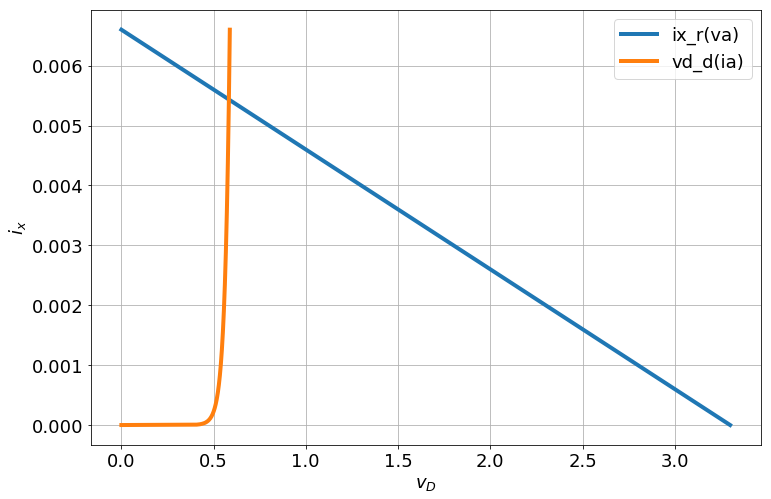

In [9]:
show()

Run the guess-and-iterate again.  Use the same initial guess $v_D = 1.65 V$.

In [10]:
ix, vd, s = iterate(ix_r, vd_d, 1.65, [0, 3.3], [0, 6.6e-3])

0: ix_r( +1.65e+00 ) =>  3.30e-03
0: vd_d( +3.30e-03 ) =>  5.70e-01
1: ix_r( +5.70e-01 ) =>  5.46e-03
1: vd_d( +5.46e-03 ) =>  5.83e-01
2: ix_r( +5.83e-01 ) =>  5.43e-03
2: vd_d( +5.43e-03 ) =>  5.83e-01
3: ix_r( +5.83e-01 ) =>  5.43e-03
3: vd_d( +5.43e-03 ) =>  5.83e-01
4: ix_r( +5.83e-01 ) =>  5.43e-03
4: vd_d( +5.43e-03 ) =>  5.83e-01
*** converged ***


Success!  We declared convergence after the 4th step.

To see what's going on a little better, plot the steps of the iteration on our plot of the two functions from before.

In [11]:
#reset and setup an animation

close('all')

#setup the base of the plot
fig, ax = plt.subplots()
vd = linspace(0, 3.3, 1000)
ix = linspace(0, 6.6e-3, 1000)

#dark axis lines
ax.hlines(0, 0, 1.1*max(vd), 'k')
ax.vlines(0, 0, 1.1*max(ix), 'k')

ax.plot(vd, ix_r(vd), label='ix_r(va)')
ax.plot(vd_d(ix), ix, label='vd_d(ia)')
ax.set_xlabel('$v_D$')
ax.set_ylabel('$i_x$')

ax.set_xlim([0, 2])
ax.set_ylim([0, 6e-3])
legend(loc='upper right')
grid(True)

annotations = []

def init():
    #remove annotations
    for a in annotations:
        a.remove()

def animate(i):
    #reuses the s return value from iterate()
    annotations[:] = []
    p = {'width': 1,
         'color': 'k'}
    for j in range(1, i+1):
        x0 = s[j-1][0]
        y0 = s[j-1][1]
        x1 = s[j][0]
        y1 = s[j][1]

        if j == i:
            p['color'] = 'r'
        a = ax.annotate('', [x1, y1], [x0, y0], arrowprops=p, clip_on=True)
        annotations.append(a)

init()
animate(4)

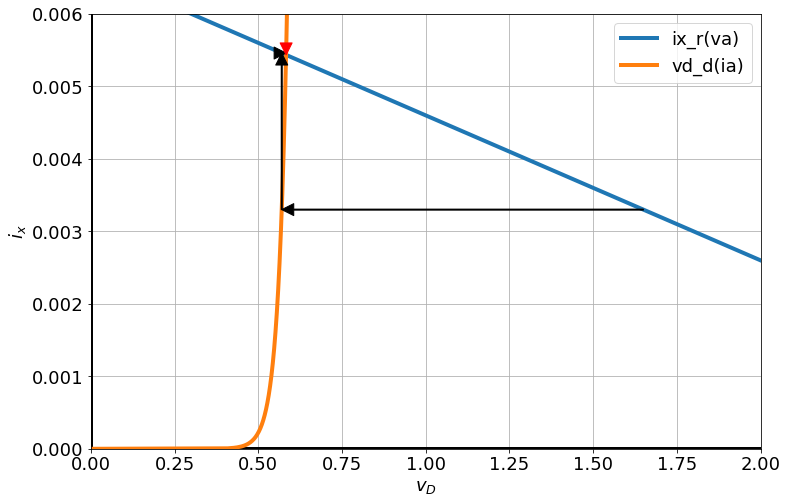

In [12]:
show()

Zoom in to the intersection

In [13]:
init()
ylim((5.4e-3, 5.5e-3))
xlim((0.56, 0.59))
animate(6)

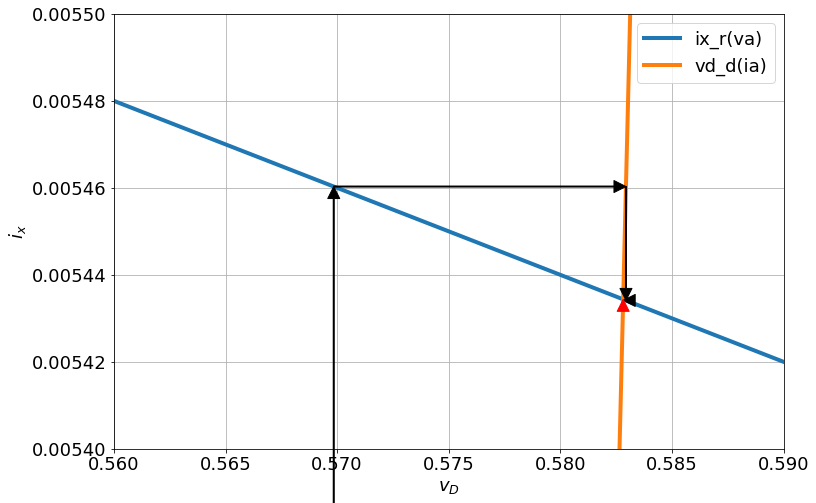

In [14]:
show()

Pretty animation in the live / HTML version

In [15]:
ax.set_xlim([0, 2])
ax.set_ylim([0, 6e-3])
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=5, interval=800); HTML(anim.to_html5_video())

# Summary

Usually, one way of writing the two mutually-coupled equations works fine while the other never works for any initial guess.

*Take note:* The one that worked had the diode equation using the $\ln()$.  This same effect is occurs with the vacuum diode equation of `hw09`.  Use the equation version solved which has the $X^{2/3}$ term instead of the $Y^{3/2}$ term.  One function has increasing slope as the input increases, the other "flattens out" as the input gets larger.

Kind of makes you want to take a few more math courses like **MATH 370 Numerical Analysis** or **MATH 334 Complex Variables**, doesn't it?